# Create a MajorTOM grid

In [ ]:
import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deepfreezer.utils import ROOT_DIR
from deepfreezer.grid import MajorTOMGrid

### Custom Implementation

In [ ]:
DIST_M = 500_000

mygrid = MajorTOMGrid(dist=DIST_M)
mypoints = mygrid.points
mypoints

,lon_idx,lat_idx,lon,lat,lon_spacing,geometry
0,0,0,-180.000000,-90.000000,180.000000,POINT (-180 -90)
1,1,0,0.000000,-90.000000,180.000000,POINT (0 -90)
2,0,1,-180.000000,-85.609756,51.428571,POINT (-180 -85.60976)
3,1,1,-128.571429,-85.609756,51.428571,POINT (-128.57143 -85.60976)
4,2,1,-77.142857,-85.609756,51.428571,POINT (-77.14286 -85.60976)
...,...,...,...,...,...,...
2109,2,40,-77.142857,85.609756,51.428571,POINT (-77.14286 85.60976)
2110,3,40,-25.714286,85.609756,51.428571,POINT (-25.71429 85.60976)
2111,4,40,25.714286,85.609756,51.428571,POINT (25.71429 85.60976)
2112,5,40,77.142857,85.609756,51.428571,POINT (77.14286 85.60976)


In [7]:
from shapely.geometry import Polygon, box

aoi = Polygon(
    [
        [-10, 10],
        [5, 10],
        [5, 40],
        [20, 40],
        [20, 10],
        [30, 10],
        [30, 65],
        [-10, 65],
        [-10, 10],
    ]
)
global_extend = box(-180, -85, 180, 85)

In [14]:
mycells_global = mygrid.get_cells(global_extend)
mycells_aoi = mygrid.get_cells(aoi)
mycells_aoi

,lon_idx,lat_idx,lon,lat,lon_spacing,id,utm_zone,geometry
1176,37,22,-13.5,6.585366,4.5,e9nmkycd,EPSG:32629,"POLYGON ((-13.5 6.58537, -9 6.58537, -9 10.975..."
1177,38,22,-9.0,6.585366,4.5,ec1t7ny6,EPSG:32629,"POLYGON ((-9 6.58537, -4.5 6.58537, -4.5 10.97..."
1178,39,22,-4.5,6.585366,4.5,echv3wg4,EPSG:32630,"POLYGON ((-4.5 6.58537, 0 6.58537, 0 10.97561,..."
1179,40,22,0.0,6.585366,4.5,s10j2nb4,EPSG:32631,"POLYGON ((0 6.58537, 4.5 6.58537, 4.5 10.97561..."
1180,41,22,4.5,6.585366,4.5,s15jqquf,EPSG:32632,"POLYGON ((4.5 6.58537, 9 6.58537, 9 10.97561, ..."
...,...,...,...,...,...,...,...,...
2001,17,35,-10.0,63.658537,10.0,gg2fhkwj,EPSG:32630,"POLYGON ((-10 63.65854, 0 63.65854, 0 68.04878..."
2002,18,35,0.0,63.658537,10.0,u5240h8j,EPSG:32631,"POLYGON ((0 63.65854, 10 63.65854, 10 68.04878..."
2003,19,35,10.0,63.658537,10.0,u5r45s9v,EPSG:32633,"POLYGON ((10 63.65854, 20 63.65854, 20 68.0487..."
2004,20,35,20.0,63.658537,10.0,u7q4phet,EPSG:32635,"POLYGON ((20 63.65854, 30 63.65854, 30 68.0487..."


<GeoAxes: >

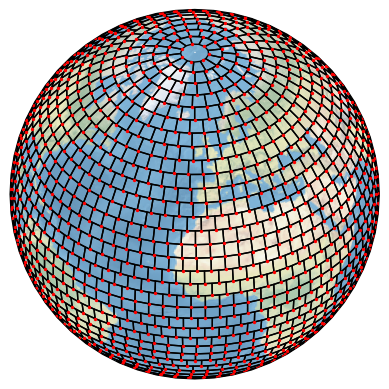

In [9]:
proj = ccrs.Orthographic(-10, 40)

fig, ax = plt.subplots(subplot_kw={"projection": proj})

ax.set_global()
ax.stock_img()
mycells_global.plot(
    ax=ax, edgecolor="black", facecolor="None", transform=ccrs.Geodetic()
)
mypoints.plot(ax=ax, markersize=2, color="red", transform=ccrs.PlateCarree(), zorder=3)

<GeoAxes: >

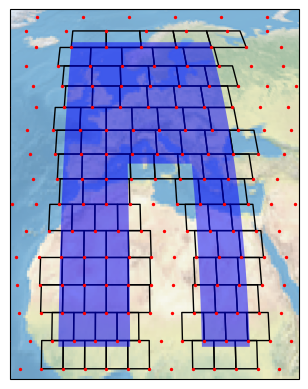

In [10]:
proj = ccrs.EqualEarth()
proj.threshold = proj.threshold / 100.0

fig, ax = plt.subplots(subplot_kw={"projection": proj})

ax.set_extent([-20, 40, 5, 75], crs=ccrs.PlateCarree())
ax.stock_img()
mycells_aoi.plot(
    ax=ax, edgecolor="black", facecolor="None", transform=ccrs.PlateCarree()
)
gpd.GeoSeries(aoi, crs=4326).plot(
    ax=ax, color="blue", alpha=0.5, transform=ccrs.PlateCarree()
)
mypoints.plot(ax=ax, markersize=2, color="red", transform=ccrs.PlateCarree(), zorder=3)

In [11]:
sgi = gpd.read_file(ROOT_DIR / "data/raw/inventory_sgi2016_r2020/SGI_2016_glaciers.shp")

WGS84 = "EPSG:4326"
CEA = "+proj=cea"

# Clean file
sgi = sgi.drop(columns="pk_glacier")
sgi.gid = sgi.gid.astype(int)
sgi = sgi.set_index("gid", verify_integrity=True).sort_index().to_crs(WGS84)

# Get a single shape of the union
sgi_union = sgi.union_all()

In [12]:
grid = MajorTOMGrid(dist=10_000)
cells = grid.get_cells(aoi=sgi_union, buffer_ratio=0.05)
cells

,lon_idx,lat_idx,lon,lat,lon_spacing,id,utm_zone,geometry
4390552,1452,1512,7.086614,45.808383,0.128848,u0jh970m,EPSG:32632,"POLYGON ((7.08017 45.80389, 7.2219 45.80389, 7..."
4390553,1453,1512,7.215462,45.808383,0.128848,u0jhs5nj,EPSG:32632,"POLYGON ((7.20902 45.80389, 7.35075 45.80389, ..."
4390554,1454,1512,7.344309,45.808383,0.128848,u0jhx55v,EPSG:32632,"POLYGON ((7.33787 45.80389, 7.4796 45.80389, 7..."
4393342,1448,1513,6.905701,45.898204,0.129079,u0hvj5s8,EPSG:32632,"POLYGON ((6.89925 45.89371, 7.04123 45.89371, ..."
4393343,1449,1513,7.034779,45.898204,0.129079,u0jj05d8,EPSG:32632,"POLYGON ((7.02833 45.89371, 7.17031 45.89371, ..."
...,...,...,...,...,...,...,...,...
4423776,1448,1524,10.317634,46.886228,0.131435,u0r6dz3h,EPSG:32632,"POLYGON ((10.31106 46.88174, 10.45564 46.88174..."
4426502,1435,1525,8.884826,46.976048,0.131627,u0q74ptx,EPSG:32632,"POLYGON ((8.87824 46.97156, 9.02303 46.97156, ..."
4426503,1436,1525,9.016453,46.976048,0.131627,u0q7jptx,EPSG:32632,"POLYGON ((9.00987 46.97156, 9.15466 46.97156, ..."
4431965,1433,1527,9.244314,47.155689,0.132062,u0qs627t,EPSG:32632,"POLYGON ((9.23771 47.1512, 9.38298 47.1512, 9...."


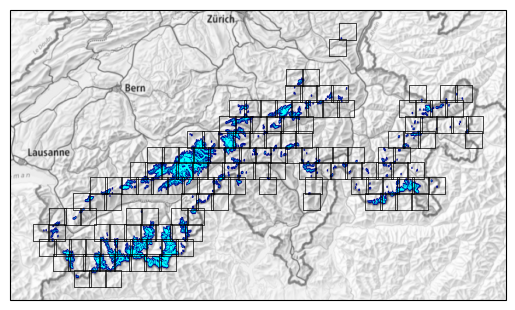

In [13]:
# Add buffer to SGI for visualization
sgi_buffered = sgi.to_crs(CEA).simplify(100).buffer(500).to_crs(WGS84)

proj = ccrs.UTM(32)
fig, ax = plt.subplots(subplot_kw={"projection": proj})

sgi_buffered.plot(ax=ax, color="darkblue")
sgi.plot(ax=ax, color="cyan")
cells.plot(ax=ax, edgecolor="black", linewidth=0.5, color="None")

cx.add_basemap(
    ax,
    crs=sgi.crs,
    # source=cx.providers.OpenStreetMap.Mapnik,
    source=cx.providers.SwissFederalGeoportal.NationalMapGrey,
    attribution=False,
)
